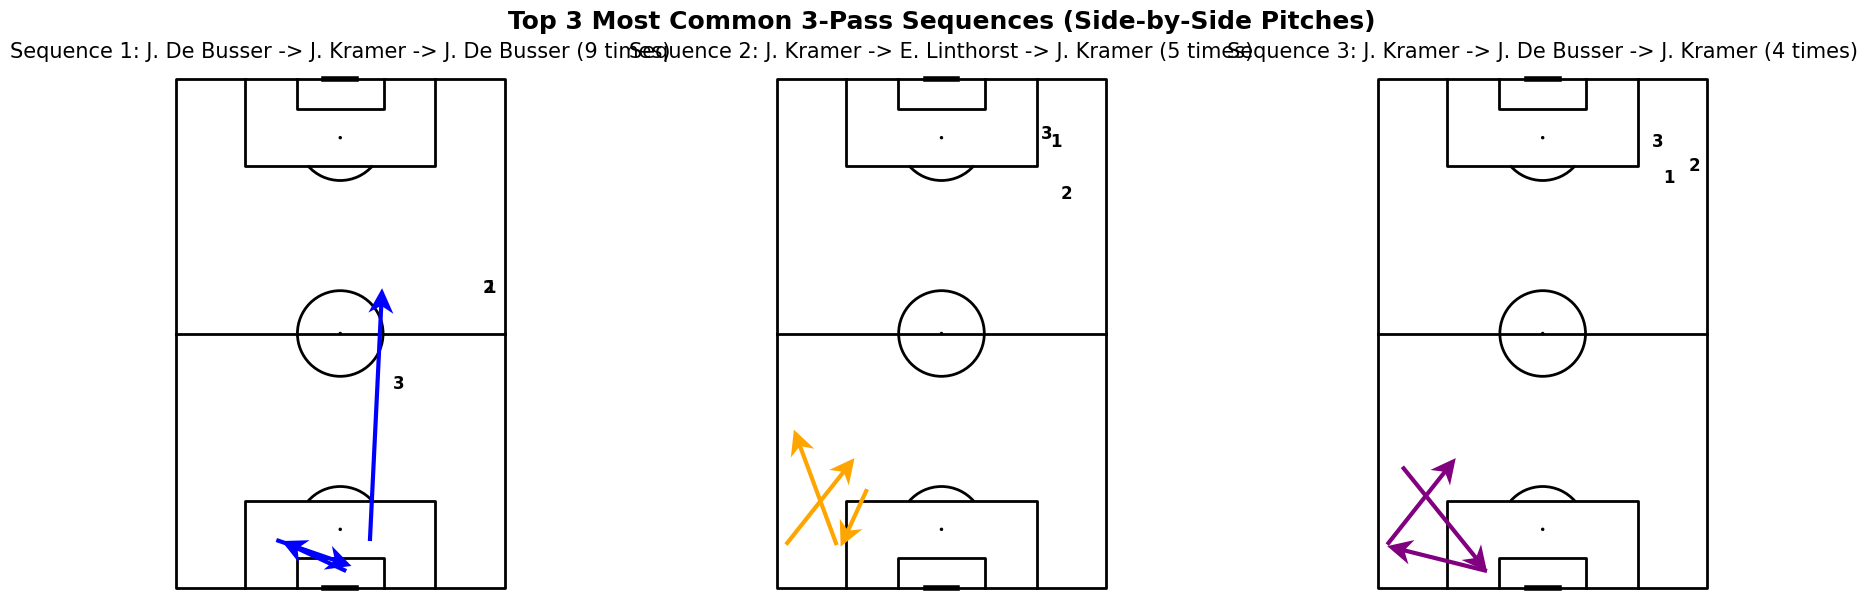

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
from collections import Counter

# Load the CSV file
file_path = '/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie 2024-2025/Go Ahead 2-2 Twente.csv'
df = pd.read_csv(file_path)

# Extract endX and endY from qualifiers
type_cols = [col for col in df.columns if '/qualifierId' in col]
df['endX'] = 0.0
df['endY'] = 0.0

for i in range(len(df)):
    df1 = df.iloc[i:i + 1, :]
    
    for j in range(len(type_cols)):
        if df1[type_cols[j]].values[0] == 140:
            df.at[i, 'endX'] = pd.to_numeric(df1[f'qualifier/{j}/value'].values[0], errors='coerce')
        if df1[type_cols[j]].values[0] == 141:
            df.at[i, 'endY'] = pd.to_numeric(df1[f'qualifier/{j}/value'].values[0], errors='coerce')

# Ensure coordinates are numeric
df[['x', 'y', 'endX', 'endY']] = df[['x', 'y', 'endX', 'endY']].apply(pd.to_numeric, errors='coerce')

# Filter only pass events and drop rows with missing coordinates
passes = df[df['typeId'] == 1].dropna(subset=['x', 'y', 'endX', 'endY'])

# Extract sequences of three passes and their coordinates
three_pass_sequences = []
three_pass_coords = []

for i in range(len(passes) - 2):
    sequence = list(passes.iloc[i:i + 3]['playerName'])
    coords = passes.iloc[i:i + 3][['x', 'y', 'endX', 'endY']].values.tolist()
    
    if len(sequence) == 3:
        three_pass_sequences.append(tuple(sequence))
        three_pass_coords.append(coords)

# Count occurrences and get top 3 sequences
sequence_counts = Counter(three_pass_sequences)
top_3_sequences = sequence_counts.most_common(3)

# Prepare pitches for visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Create a pitch for each sequence
colors = ['blue', 'orange', 'purple']
pitch = VerticalPitch(pitch_type='opta', pitch_color='white', line_color='black', half=False)

for idx, (sequence, count) in enumerate(top_3_sequences):
    ax = axes[idx]
    pitch.draw(ax=ax)
    
    coords = three_pass_coords[three_pass_sequences.index(sequence)]
    
    for pass_idx, (x, y, endX, endY) in enumerate(coords):
        # Plot the pass arrow
        pitch.arrows(x, y, endX, endY, width=3, headwidth=6, headlength=6, color=colors[idx], ax=ax)
        
        # Compute label position (near the middle of the arrow)
        label_x = (x + endX) / 2
        label_y = (y + endY) / 2
        
        # Label each pass next to the arrow
        ax.text(label_x, label_y, f"{pass_idx + 1}", fontsize=12, color='black', fontweight='bold')
    
    ax.set_title(f"Sequence {idx + 1}: {' -> '.join(sequence)} ({count} times)", fontsize=15)

# Show the plot
plt.suptitle("Top 3 Most Common 3-Pass Sequences (Side-by-Side Pitches)", fontsize=18, fontweight='bold')
plt.show()
